In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import random
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
Tickers = df['Symbol'].to_numpy().tolist()
i1=Tickers.index('BF.B')
i2=Tickers.index('BRK.B')
i3 =Tickers.index('ENPH')
Tickers[i3]='TIF'
Tickers[i1]='BF-B'
Tickers[i2]='BRK-B'

In [3]:
#df =  yf.download(tickers=Tickers, period='1y') # Download Data from Yahoo Finance
df =  yf.download(tickers=Tickers, start="2020-01-01", end="2020-12-31")

[*********************100%***********************]  505 of 505 completed


In [4]:
# Take the Adjusted Returns from the data for the companies that are in the list for at least 10 years
df=df['Adj Close']

In [5]:
df1 = df[1:]
df0 = df[:-1]
pt1 = df1.reset_index(drop=True)
pt0 = df0.reset_index(drop=True)
ret = (pt1-pt0)/pt0
ret.index = df1.index
train_size = int(len(ret) * 0.75)
train_ret, test_ret = ret[0:train_size], ret[train_size:]
valtrain_size = int(len(train_ret) * 0.80)
train_ret2, val_ret = train_ret[0:valtrain_size], train_ret[valtrain_size:]
lst=[]
for col in df.columns:
    if df[col].isna().sum() > 0:
        lst.append(col)
ret.drop(columns=lst,inplace=True)

In [6]:
arima_data=pd.read_csv('prediction_arima_withdatev2.csv')
arima_data.set_index('Date',inplace=True)
lstm_data=pd.read_csv('lstm_pred.csv')
lstm_data.set_index('Date',inplace=True)
arima_data_new = arima_data.loc[lstm_data.index]
observed_data = ret.iloc[-58:]
observed_data = observed_data.reindex(lstm_data.index)

In [7]:
cols=[]
for col in arima_data_new.columns:
    if arima_data_new[col][0]=='#VALUE!':
        cols.append(col)
for col in cols:
    arima_data_new[col]= ret[col].mean()    

In [8]:
arima_rmse = []
lstm_rmse = []
for col in arima_data_new.columns:
    arima_rmse.append( mean_squared_error(observed_data[col], arima_data_new[col], squared=False))
    lstm_rmse.append(mean_squared_error(observed_data[col], lstm_data[col], squared=False))

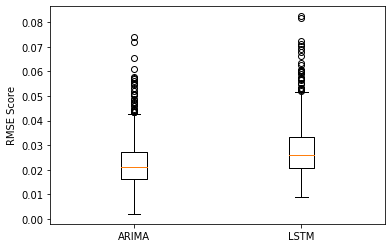

In [32]:
all_rmse = [arima_rmse,lstm_rmse]
labels = ['ARIMA', 'LSTM']
plt.boxplot(all_rmse, vert=True,labels=labels)
plt.ylabel('RMSE Score')
plt.show()

Text(0, 0.5, 'RMSE Score Difference (ARIMA-LSTM) of Individual Stock')

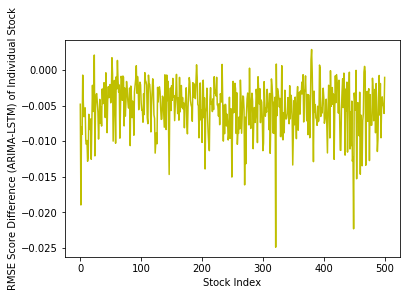

In [51]:
a=np.array(arima_rmse)-np.array(lstm_rmse)
plt.plot(range(len(lstm_rmse)), a,color='y')
plt.xlabel('Stock Index')
plt.ylabel('RMSE Score Difference (ARIMA-LSTM) of Individual Stock')

In [17]:
observed_data_class = observed_data.copy()
observed_data_class[observed_data_class<0]=0
observed_data_class[observed_data_class>0]=1
arima_data_class = arima_data_new.copy()
arima_data_class[arima_data_class<0]=0
arima_data_class[arima_data_class>0]=1
lstm_data_class = lstm_data.copy()
lstm_data_class[lstm_data_class<0]=0
lstm_data_class[lstm_data_class>0]=1

In [18]:
arima_acc = []
lstm_acc = []
for col in arima_data_class.columns:
    arima_acc.append( accuracy_score(observed_data_class[col], arima_data_class[col]))
    lstm_acc.append(accuracy_score(observed_data_class[col], lstm_data_class[col]))

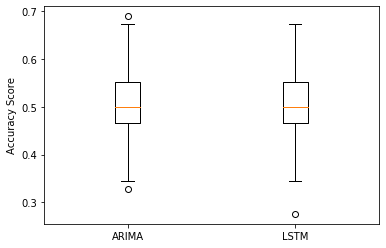

In [33]:
all_acc = [arima_acc,lstm_acc]
labels = ['ARIMA', 'LSTM']
plt.boxplot(all_acc, vert=True,labels=labels)
plt.ylabel('Accuracy Score')
plt.show()
plt.show()

Text(0, 0.5, 'Accuracy Score Difference (ARIMA-LSTM) of Individual Stock')

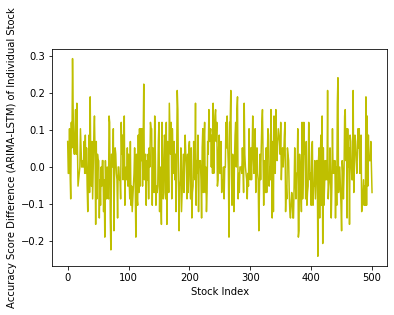

In [52]:
b=np.array(arima_acc)-np.array(lstm_acc)
plt.plot(range(len(lstm_acc)), b,color='y')
plt.xlabel('Stock Index')
plt.ylabel('Accuracy Score Difference (ARIMA-LSTM) of Individual Stock')